# CAPSTONE PROJECT
## by SHUO ZENG
## 神策数据

○ 公司介绍:国内领先的用户行为分析产品

○ 数据内容: 该公司官网访问约一周的数据,包括用户访问时产生的点击按钮、申请
账号、提交验证码、观看视频、离开页面等行为记录。详细的日志描述并配以官方
技术文档以及API手册说明。

○ 项目目标:
- Clean dirty log data and transform it for analytics.
- Exploratory data analysis, e.g. find user activity levels for different events,
and user interaction with web components.
- Find the conversion rate of users, identify key factors that bottleneck the
conversion rate.
- Propose any hypothesis and set up experiments for testing.
- Build machine learning models to predict user behaviors, including but not
limited to signup, churn, etc.
- Discover interesting insights in the dataset and suggest how to improve
the user signup rate.

## Cleaned the dirty log data
### (saved the code in 'parse.py')

import json

with open('sensorswww_data.txt', 'r') as f:
	data_strings = f.read()

data_strings = ''.join(data_strings.split())

data = []
start = curr = 0
num_braces = 0
while curr < len(data_strings):
	if data_strings[curr] == '{':
		num_braces += 1
	elif data_strings[curr] == '}':
		num_braces -= 1
	
	if num_braces == 0:
		s = data_strings[start:curr + 1]
		p_obj = json.loads(s)
		data.append(p_obj)
		start = curr + 1
	
	curr += 1

with open('new_data.json', 'w') as f:
	json.dump(data, f, sort_keys=True, indent=4)


## Load the Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import calendar

In [4]:
sensordata = pd.read_json("new_data.json")
#sensordata.head(3)

In [5]:
# Splitting 'properties' from dictionary inside a Pandas Column into Separate Columns
sensor_properties = sensordata.properties.apply(pd.Series) 
#sensor_properties.head()

In [6]:
#concatenate sensordata with the sensor_properties, remove three columns
sensor_new = pd.concat([sensordata.drop(['_nocache','properties','lib','jssdk_error'],axis=1),sensor_properties], axis = 1)

In [7]:
# convert timestamp to date
from datetime import datetime
sensor_new['date'] = sensor_new['time'].apply(lambda x:datetime.fromtimestamp(x/1000).date())
sensor_new = sensor_new.drop('time',axis=1)
sensor_new.head(3)

,distinct_id,event,type,$browser,$browser_version,$first_browser_language,$first_referrer,$first_referrer_host,$first_visit_time,$ip,...,referrHostUrl,referrerUrl,requestBtn,result,session_page_url,siteUrl,site_url,url_path,verification_code,date
0,595466e9a8e733434ce08de16e927d985e0b5d48,index_leave,track,chrome,56,NaN,NaN,NaN,NaN,219.135.131.99,...,NaN,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,2017-03-06
1,9939d3e087bca29c42334d96dccd25ca0e06652a,NaN,profile_set_once,NaN,NaN,zh-CN,,,2017-03-0617:04:10.999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-31
2,9939d3e087bca29c42334d96dccd25ca0e06652a,$pageview,track,chrome,56,NaN,NaN,NaN,NaN,111.204.198.242,...,NaN,NaN,NaN,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06


## Exploratory data analysis
### (1) inspect the user# on daily basis

In [11]:
## Daily visits number by all users
daily_all_visit = sensor_new.groupby('date').distinct_id.count().reset_index()
daily_all_visit['weekday'] = daily_all_visit['date'].apply(lambda x:calendar.day_name[x.weekday()])
daily_all_visit

,date,distinct_id,weekday
0,2017-03-06,8051,Monday
1,2017-03-07,8770,Tuesday
2,2017-03-08,8849,Wednesday
3,2017-03-09,10304,Thursday
4,2017-03-10,5164,Friday
5,2017-03-11,2658,Saturday
6,2017-03-12,5718,Sunday
7,2017-03-13,10078,Monday
8,2017-03-14,6081,Tuesday
9,2017-03-31,9419,Friday


In [12]:
# Daily visits number by new_users

daily_new_visit = sensor_new[sensor_new['$is_first_time'] == True].groupby('date').distinct_id.count().reset_index()
daily_new_visit['weekday'] = daily_new_visit['date'].apply(lambda x:calendar.day_name[x.weekday()])
daily_new_visit

,date,distinct_id,weekday
0,2017-03-06,1127,Monday
1,2017-03-07,1208,Tuesday
2,2017-03-08,1349,Wednesday
3,2017-03-09,1345,Thursday
4,2017-03-10,743,Friday
5,2017-03-11,537,Saturday
6,2017-03-12,948,Sunday
7,2017-03-13,1246,Monday
8,2017-03-14,872,Tuesday


In [13]:
daily_visit_data = daily_all_visit.merge(daily_new_visit,how = 'left',on = 'date')
daily_visit_data = daily_visit_data.drop('weekday_x',axis =1 )
daily_visit_data

#daily_new_visit.plot(x='weekday',y='distinct_id',kind = 'bar')

,date,distinct_id_x,distinct_id_y,weekday_y
0,2017-03-06,8051,1127.0,Monday
1,2017-03-07,8770,1208.0,Tuesday
2,2017-03-08,8849,1349.0,Wednesday
3,2017-03-09,10304,1345.0,Thursday
4,2017-03-10,5164,743.0,Friday
5,2017-03-11,2658,537.0,Saturday
6,2017-03-12,5718,948.0,Sunday
7,2017-03-13,10078,1246.0,Monday
8,2017-03-14,6081,872.0,Tuesday
9,2017-03-31,9419,NaN,NaN


In [14]:
daily_visit_data.columns = ['date','all visits','new_visits','weekday']
daily_visit_data['new_user_ratio'] = daily_visit_data['new_visits']/daily_visit_data['all visits']

In [15]:
daily_visit_data[['date','weekday','all visits','new_visits','new_user_ratio']]

,date,weekday,all visits,new_visits,new_user_ratio
0,2017-03-06,Monday,8051,1127.0,0.139983
1,2017-03-07,Tuesday,8770,1208.0,0.137742
2,2017-03-08,Wednesday,8849,1349.0,0.152447
3,2017-03-09,Thursday,10304,1345.0,0.130532
4,2017-03-10,Friday,5164,743.0,0.143881
5,2017-03-11,Saturday,2658,537.0,0.202032
6,2017-03-12,Sunday,5718,948.0,0.165792
7,2017-03-13,Monday,10078,1246.0,0.123636
8,2017-03-14,Tuesday,6081,872.0,0.143397
9,2017-03-31,NaN,9419,NaN,NaN


Text(0,0.5,'number of visits')

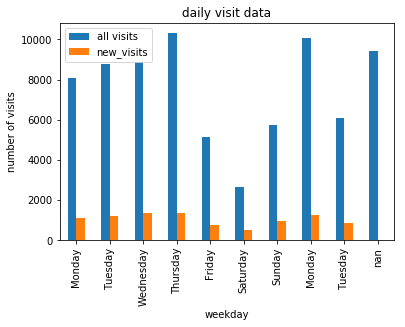

In [16]:
daily_visit_data.plot(x='weekday',y=['all visits','new_visits'], kind = 'bar')
plt.title('daily visit data')
plt.xlabel('weekday')
plt.ylabel('number of visits')

### From the above data
- we can see the new user is around 12%-14% of the total users
- Staturday's new user ratio is higher than normal (20%), if we have more date's data, we can verify if Saturday attracts more new users
- More users during weekday, lower users from Friday to Sunday.

### (2) inspect the user_activity (existing users)
- (define no activity within 8 days?)

In [17]:
sensor_user = sensor_new[['distinct_id','event','date','$is_first_time']].sort_values('distinct_id')

In [18]:
sensor_existing_user = sensor_user[sensor_user['$is_first_time'] == False]
sensor_existing_user.head()

,distinct_id,event,date,$is_first_time
6932,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,btnClick,2017-03-06,False
6935,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,click_send_cellphone,2017-03-06,False
6943,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,click_send_cellphone,2017-03-06,False
6948,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,formSubmit,2017-03-06,False
6949,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,verify_cellphone_code,2017-03-06,False


In [19]:
# sensor_merge = sensor_existing_user.merge(sensor_existing_user, on = 'distinct_id') 
# # sensor_merge

In [20]:
date1 = sensor_existing_user.groupby('distinct_id').date.min().reset_index()
date2 = sensor_existing_user.groupby('distinct_id').date.max().reset_index()
existing_user_date = date1.merge(date2,on = 'distinct_id')
existing_user_date

,distinct_id,date_x,date_y
0,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,2017-03-06,2017-03-06
1,000a216b72eff19bd0d5e17b9e676dd6ad9a38ac,2017-03-12,2017-03-12
2,000c46a27ef69fa22b56d253a9c72773338a1686,2017-03-06,2017-03-06
3,000ed1dcd942969b458c5b308937c6389c08f999,2017-03-12,2017-03-12
4,0011f5066b1c62717255852fdb15a0473a5c2b19,2017-03-08,2017-03-08
5,0012ea1b517e6959354abaa6954711054ec831b9,2017-03-06,2017-03-06
6,002232cd6da95fae1cc9a5fbaa7c2d0e11fbd57b,2017-03-09,2017-03-09
7,00229f012ef316de6efdcbc380ffdb2558e9ff81,2017-03-08,2017-03-08
8,002d8f97faecdd57156c648b3214e6ace810d974,2017-03-14,2017-03-14
9,002e2c1cd393b3d240ef46c45990c76f9b37a182,2017-03-07,2017-03-07


In [21]:
existing_user_date['diff'] = existing_user_date['date_y'] - existing_user_date['date_x']
existing_user_date.columns = ['distinct_id','first_date','last_date','diff']

In [22]:
existing_user_date['diff'].describe()

count                      9030
mean     0 days 10:29:15.747508
std      1 days 08:55:39.408322
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 00:00:00
75%             0 days 00:00:00
max             8 days 00:00:00
Name: diff, dtype: object

In [23]:
existing_user_date.sort_values('diff',ascending = False).head()

,distinct_id,first_date,last_date,diff
8733,f7ef4d826308aae715a4a858b24986e5327c3ff7,2017-03-06,2017-03-14,8 days
7022,c6ceca1c2b8cfb99816f3109e749a84438c2fad1,2017-03-06,2017-03-14,8 days
5232,95c1ab00be886ec67d84ce8db1d8610035318964,2017-03-06,2017-03-14,8 days
5236,95cd75560edb05c1a4e097da927a5c8301e6851c,2017-03-06,2017-03-14,8 days
3778,6be98e59a1f3ced1a521fdc2c4c4da2355d6abe3,2017-03-06,2017-03-14,8 days


In [24]:
existing_user_date[existing_user_date['diff'] == '0 days'].count()/existing_user_date['diff'].count()

distinct_id    0.856921
first_date     0.856921
last_date      0.856921
diff           0.856921
dtype: float64

In [25]:
existing_user_date[existing_user_date['diff'] != '0 days'].count()/existing_user_date['diff'].count()

distinct_id    0.143079
first_date     0.143079
last_date      0.143079
diff           0.143079
dtype: float64

### From the above data

we can see that 85.7% of the users only signed in one day during the time range of 3/6-3/14, 14.30% users signed at least two days.

As we only have 8 days data, it is hard to define if the 85.7% users are the churn users. 

But we can assume that if the users didn't sign up within 7 days, they are the churn users in this project

In [26]:
# event_map = {'index_leave':'page_leave',\
#              'demo_leave':'page_leave',\
#              'about_leave':'page_leave',\
#              'courses_leave':'page_leave',\
#              'courses_play_leave':'page_leave'}
#sensor_new['event'] = sensor_new['event'].map(event_map)

### (3) Inspect operation system and device data

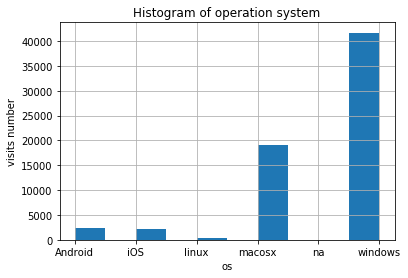

In [27]:
sensor_new['$os'].hist()
plt.title('Histogram of operation system')
plt.xlabel('os')
plt.ylabel('visits number')
plt.savefig('hist_os')

In [28]:
sensor_new['$model'].value_counts()

pc         41656
mac        19037
iphone      2059
android      760
huawei       558
na           448
vivo         267
samsung      200
mi           196
meizu        162
ipad         149
hongmi        89
nexus         56
lenovo        13
coolpad       12
htc            4
oppo           3
zte            2
lg             1
nokia          1
Name: $model, dtype: int64

## Conversion Rate
#### combine all the '_leave' to "page_leave"

In [29]:
sensor_new.loc[sensor_new.event == 'index_leave','event'] = 'page_leave'
sensor_new.loc[sensor_new.event == 'demo_leave','event'] = 'page_leave'
sensor_new.loc[sensor_new.event == 'about_leave','event'] = 'page_leave'
sensor_new.loc[sensor_new.event == 'courses_leave','event'] = 'page_leave'
sensor_new.loc[sensor_new.event == 'courses_play_leave','event'] = 'page_leave'

#### calculate conversion rate of each event by Date/ OS / Model

In [30]:
def conversion_rate(df):
    event_counts = df.event.value_counts()
    convert_from = event_counts.copy()
   
    total = df.shape[0]
    
    for page in event_counts.index:
        n_left = event_counts.loc[page] #how many users just stop at current page
        n_convert = total - n_left
        convert_from[page] = n_convert
        total = n_convert

    conv_rate = pd.concat([event_counts,convert_from], axis=1, keys=['n_drop','n_convert'])
    conv_rate['convert_rates'] = conv_rate.n_convert.astype(np.float)/(conv_rate.n_drop + conv_rate.n_convert)
    conv_rate['drop_rates'] = 1 - conv_rate['convert_rates']
    
    return conv_rate
    

#### conversion_rate by Date

In [31]:
sensor_new.groupby('date').apply(conversion_rate)

n_drop  n_convert  convert_rates  drop_rates
date                                                                          
2017-03-06 $pageview                3984       4067       0.505155    0.494845
           page_leave               2049       2018       0.496189    0.503811
           btnClick                 1714        304       0.150644    0.849356
           formSubmit                 83        221       0.726974    0.273026
           click_send_cellphone       72        149       0.674208    0.325792
           verify_cellphone_code      68         81       0.543624    0.456376
           clickSubmit                61         20       0.246914    0.753086
           page_close                 20          0       0.000000    1.000000
2017-03-07 $pageview                4312       4458       0.508324    0.491676
           page_leave               2241       2217       0.497308    0.502692
           btnClick                 1815        402       0.181326    0.818674
           formSubmit                109        293       0.728856    0.271144
           clickSubmit                90        203       0.692833    0.307167
           click_send_cellphone       89        114       0.561576    0.438424
           verify_cellphone_code      79         35       0.307018    0.692982
           page_close                 35          0       0.000000    1.000000
2017-03-08 $pageview                4410       4439       0.501639    0.498361
           page_leave               2250       2189       0.493129    0.506871
           btnClick                 1831        358       0.163545    0.836455
           formSubmit                101        257       0.717877    0.282123
           click_send_cellphone       80        177       0.688716    0.311284
           verify_cellphone_code      77        100       0.564972    0.435028
           clickSubmit                65         35       0.350000    0.650000
           page_close                 35          0       0.000000    1.000000
2017-03-09 $pageview                5055       5249       0.509414    0.490586
           page_leave               2557       2692       0.512860    0.487140
           btnClick                 2268        424       0.157504    0.842496
           formSubmit                142        282       0.665094    0.334906
           verify_cellphone_code      90        192       0.680851    0.319149
           click_send_cellphone       90        102       0.531250    0.468750
...                                  ...        ...            ...         ...
2017-03-11 btnClick                  511        110       0.177134    0.822866
           formSubmit                 37         73       0.663636    0.336364
           clickSubmit                25         48       0.657534    0.342466
           click_send_cellphone       24         24       0.500000    0.500000
           verify_cellphone_code      22          2       0.083333    0.916667
           page_close                  2          0       0.000000    1.000000
2017-03-12 $pageview                3001       2717       0.475166    0.524834
           page_leave               1402       1315       0.483990    0.516010
           btnClick                 1152        163       0.123954    0.876046
           formSubmit                 43        120       0.736196    0.263804
           verify_cellphone_code      39         81       0.675000    0.325000
           click_send_cellphone       38         43       0.530864    0.469136
           clickSubmit                32         11       0.255814    0.744186
           page_close                 11          0       0.000000    1.000000
2017-03-13 $pageview                4970       5108       0.506847    0.493153
           page_leave               2468       2640       0.516836    0.483164
           btnClick                 2190        450       0.170455    0.829545
           formSubmit                119        331       0.735556    0.264444
     

#### conversion_Rate by OS

In [32]:
sensor_new['$os'].value_counts()

windows    41656
macosx     19037
Android     2324
iOS         2208
linux        411
na            37
Name: $os, dtype: int64

In [33]:
ios_cr = sensor_new.groupby('$os').apply(conversion_rate).reset_index().sort_values(['$os','n_drop'], ascending = False)

In [34]:
ios_cr[(ios_cr['$os'] == 'windows') |
         (ios_cr['$os'] == 'macosx')]

,$os,level_1,n_drop,n_convert,convert_rates,drop_rates
28,windows,$pageview,19620,22036,0.528999,0.471001
29,windows,page_leave,11231,10805,0.490334,0.509666
30,windows,btnClick,8993,1812,0.167700,0.832300
31,windows,formSubmit,540,1272,0.701987,0.298013
32,windows,click_send_cellphone,402,870,0.683962,0.316038
33,windows,verify_cellphone_code,386,484,0.556322,0.443678
34,windows,clickSubmit,347,137,0.283058,0.716942
35,windows,page_close,137,0,0.000000,1.000000
17,macosx,$pageview,9360,9677,0.508326,0.491674
18,macosx,page_leave,4766,4911,0.507492,0.492508


#### conversion rate by device model

In [35]:
#sensor_new.groupby('$model').apply(conversion_rate).reset_index().sort_values(['$model','n_drop'], ascending = False)

In [36]:
model_cr = sensor_new.groupby('$model').apply(conversion_rate).reset_index().sort_values(['$model','n_drop'], ascending = False)

In [37]:
model_cr[(model_cr['$model'] == 'iphone') | 
         (model_cr['$model'] == 'android') | 
         (model_cr['$model'] == 'mac') |
        (model_cr['$model'] == 'pc')]

,$model,level_1,n_drop,n_convert,convert_rates,drop_rates
69,pc,$pageview,19620,22036,0.528999,0.471001
70,pc,page_leave,11231,10805,0.490334,0.509666
71,pc,btnClick,8993,1812,0.167700,0.832300
72,pc,formSubmit,540,1272,0.701987,0.298013
73,pc,click_send_cellphone,402,870,0.683962,0.316038
74,pc,verify_cellphone_code,386,484,0.556322,0.443678
75,pc,clickSubmit,347,137,0.283058,0.716942
76,pc,page_close,137,0,0.000000,1.000000
36,mac,$pageview,9360,9677,0.508326,0.491674
37,mac,page_leave,4766,4911,0.507492,0.492508


In [38]:
#model_cr[model_cr['level_1'] == 'formSubmit'].sort_values('drop_rates',ascending = False)

### bottleneck of the conversion rate
From the conversion rate, I could see the big drop from btnclick to click_send_cellphone. Few users converted to fill the demo experience page by inputting cellphone number. 
 
The reason for this that I could think of is that users are not willing to provide cellphone#, or don't have china cellphone# (like the people live in US). 

If SensorData Website could offer more options for registration like using email, maybe more users are willing to register or able to register to get more exprience on the product. 


## Propose any hypothesis and set up experiments for testing.

### Hypothesis:

Email registration could increase the sign up rate

### Set up A/B Testing

(1) Control Group:
     - Group0 : Keep the existing option - the cellphone registration

(2) Experiment Groups: 
     - Group1: Remove the cellphone registration, replace it by Email Registration
     - Group2: Keep the celphone registration, and add Email Registration as an option
 
Determine the sample size of the three groups, and Run the testing for one week and using cohort analysis to analyze the sign up conversion rate. If the result is significant, then we can report to the management team to decide if to launch the new features




## Build machine learning models to predict user behaviors

### (1) Label the row that event = 'formSubmit' as 'signup'

In [39]:
def label_row(row):
    if row['event'] == 'formSubmit':
        return 'Yes'
    else:
        return 'No'  

In [40]:
sensor_new_copy = sensor_new.copy()

In [41]:
sensor_new_copy['signup'] = sensor_new_copy.apply(lambda row:label_row(row), axis = 1)

In [54]:
sensor_new_copy['signup'].value_counts()

No     74301
Yes      791
Name: signup, dtype: int64

 ### (2) Label the distinct_id if 'signup' = 'Yes'

In [55]:
distinct_id_signup = sensor_new_copy.loc[sensor_new_copy['signup'] == 'Yes', 'distinct_id']

In [58]:
distinct_id_signup.count()

791

In [63]:
def update_signup(df):
    for item in df['signup']:
         if item == 'No':
                df['signup']= 'Yes'
    return df

In [64]:
sensor_signup_user = update_signup(sensor_new_copy[sensor_new_copy.distinct_id.isin(distinct_id_signup) == True])

/Users/shuo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [66]:
sensor_signup_user.head()

,distinct_id,event,type,$browser,$browser_version,$first_browser_language,$first_referrer,$first_referrer_host,$first_visit_time,$ip,...,referrerUrl,requestBtn,result,session_page_url,siteUrl,site_url,url_path,verification_code,date,signup
206,05275c9a86246309de06ef9e9443dbecb2d9e432,NaN,profile_set_once,NaN,NaN,NaN,http://www.baidu.com/baidu.php?sc.7aTK000CsN4T...,www.baidu.com,2017-03-0617:16:04.716,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-31,Yes
207,05275c9a86246309de06ef9e9443dbecb2d9e432,$pageview,track,ie,8,NaN,NaN,NaN,NaN,116.231.5.148,...,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,2017-03-06,Yes
211,05275c9a86246309de06ef9e9443dbecb2d9e432,btnClick,track,ie,8,NaN,NaN,NaN,NaN,116.231.5.148,...,NaN,10,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,2017-03-06,Yes
223,05275c9a86246309de06ef9e9443dbecb2d9e432,page_leave,track,ie,8,NaN,NaN,NaN,NaN,116.231.5.148,...,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,2017-03-06,Yes
224,05275c9a86246309de06ef9e9443dbecb2d9e432,click_send_cellphone,track,ie,8,NaN,NaN,NaN,NaN,116.231.5.148,...,NaN,NaN,ajaxsuccess,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,2017-03-06,Yes


In [67]:
sensor_notsign_user = sensor_new_copy[sensor_new_copy.distinct_id.isin(distinct_id_signup) == False]

In [68]:
sensor_labeled_user = pd.concat([sensor_signup_user,sensor_notsign_user])

### (3) group user by distinct_id, date, os, model, and count the event#

In [69]:
data = sensor_labeled_user.groupby(['distinct_id','signup','$os','$os_version','$model','$browser']).event.count().reset_index()
data.head()

,distinct_id,signup,$os,$os_version,$model,$browser,event
0,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,Yes,iOS,10.2,iphone,qq,6
1,000a216b72eff19bd0d5e17b9e676dd6ad9a38ac,No,macosx,10.12,mac,chrome,1
2,000c46a27ef69fa22b56d253a9c72773338a1686,No,windows,10,pc,chrome,22
3,000ed1dcd942969b458c5b308937c6389c08f999,No,windows,10,pc,qq,4
4,00111feff544ef5280a4c7064a362a9ea59c9389,No,iOS,9,iphone,safari,1


In [ ]:
### data[data['signup'] == 'No'].event.mean() 
### data[data['signup'] == 'Yes'].event.mean() 
## sign up users have more events than not signup users

### (4) Random Forrest

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [153]:
X0 = data.loc[:,('$os','$model','$browser')]
X0 = pd.get_dummies(X0)
X0 = pd.concat([X0, data['event']],axis = 1)


In [154]:
y0 = pd.Series(np.where(data.signup == 'Yes', 1, 0), data.index)
y0.head()

0    1
1    0
2    0
3    0
4    0
dtype: int64

### Using Random Forrest to predict the user signup behavior

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [163]:
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)
    
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)


#### train and test data

In [155]:
Xtrain0,Xtest0,ytrain0,ytest0 = train_test_split(X0,y0,test_size=0.333)

/Users/shuo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shuo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              train      test
metrics                      
AUC        0.955445  0.945919
Accuracy   0.958833  0.954569
Precision  0.000000  0.000000
Recall     0.000000  0.000000
f1-score   0.000000  0.000000


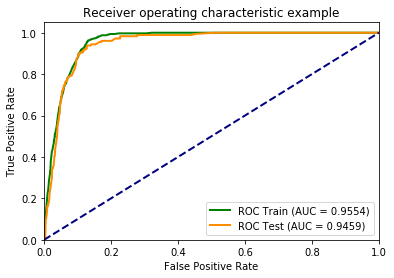

In [164]:
# Choose some parameter combinations to try
parameters = {'n_estimators': 50,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(Xtrain0, ytrain0)

# Train test model
train_test_model(clf, Xtrain0, ytrain0, Xtest0, ytest0)

#### Please note:

From above we can se that the signup precision, rechall, f1-score are extremely low, although average is over 0.90.

This is because of the imbalanced data: Not-signup# is 11263, signup# is 501.

We can use upsampling the signup users or downsampling the Not-signup users.

In [103]:
data.signup.value_counts()

No     11263
Yes      501
Name: signup, dtype: int64

#### Upsampling the signup users

In [111]:
from sklearn.utils import resample

In [109]:
# Separate majority and minority classes
df_majority = data[data.signup == 'No']
df_minority = data[data.signup == 'Yes']

In [113]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=11263,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.signup.value_counts()

No     11263
Yes    11263
Name: signup, dtype: int64

In [166]:
X1 = df_upsampled.loc[:,('$os','$model','$browser')]
X1 = pd.get_dummies(X1)
X1 = pd.concat([X1, df_upsampled['event']],axis = 1)
y1 = pd.Series(np.where(df_upsampled.signup == 'Yes', 1, 0), df_upsampled.index)
Xtrain1,Xtest1,ytrain1,ytest1 = train_test_split(X1,y1,test_size=0.333)

              train      test
metrics                      
AUC        0.958279  0.956887
Accuracy   0.909412  0.909091
Precision  0.870127  0.873458
Recall     0.961970  0.957814
f1-score   0.913746  0.913693


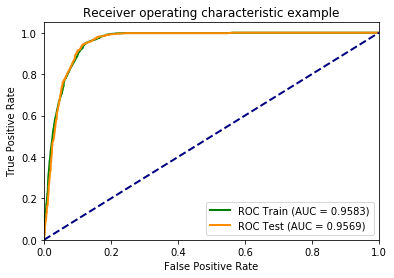

In [170]:
# Choose some parameter combinations to try
parameters = {'n_estimators': 50,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(Xtrain1, ytrain1)

# Train test model
train_test_model(clf, Xtrain1, ytrain1, Xtest1, ytest1)

#### Downsampling the not-signup users

In [171]:
#downsample majority class
df_df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=501,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_df_majority_downsampled])
 
# Display new class counts
df_downsampled.signup.value_counts()

No     501
Yes    501
Name: signup, dtype: int64

In [172]:
X2 = df_downsampled.loc[:,('$os','$model','$browser')]
X2 = pd.get_dummies(X2)
X2 = pd.concat([X2, df_downsampled['event']],axis = 1)
y2 = pd.Series(np.where(df_downsampled.signup == 'Yes', 1, 0), df_downsampled.index)
Xtrain2,Xtest2,ytrain2,ytest2 = train_test_split(X2,y2,test_size=0.333)

#### Using downsampling data run the model again

              train      test
metrics                      
AUC        0.930968  0.892601
Accuracy   0.893713  0.868263
Precision  0.869942  0.857143
Recall     0.920489  0.896552
f1-score   0.894502  0.876404


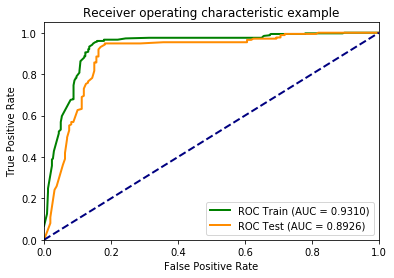

In [173]:
# Choose some parameter combinations to try
parameters = {'n_estimators': 50,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(Xtrain2, ytrain2)

# Train test model
train_test_model(clf, Xtrain2, ytrain2, Xtest2, ytest2)

### Conclusion:
- After upsampling and downsampling, the precision, recall, f1-score have better result comparing with the original training result.
- Upsampling's performance is better than downsampling. 
- Downsampling hsa overfitting issue (train AUC > test AUC). This is because the sample size is less after downsampling. 

## Discover interesting insights

Based on the pervious analysis, I think SensorData should consider add "email registration" as an option instead of only using cellphone to increase the signup rate.